# Pruning Models to prevent Backdoor attacks

## Importing Libraries, cloning github repo and downloading datasets

In [ ]:
#import libraries
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from keras import models
import h5py
import matplotlib.image as mpimg
import imageio as im

Clone the repository

In [ ]:
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
%cd /content/CSAW-HackML-2020/data

#!gdown --id 19OKCkY2CjV3ASkOe6nMSYTsOVcxAoCnA
#!gdown --id 1XtYnM-IopU-QYVc99U51EiDvI5zxK0nV
#!gdown --id 1P8PTL62x3cfpV9mrC0unqZjRFhlTTOSG
#!gdown --id 1XFKaTse6gflUFK7lDPxXBUaq4oQA8-qy

/content/CSAW-HackML-2020/data


Download the datasets from Google Drive

In [ ]:
%mkdir lab3
%cd lab3
%mkdir clean
%mkdir bad
%cd clean

#download clean data
!gdown --id 1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
!gdown --id 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf

%cd ..
%cd bad

!gdown --id 1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy
!gdown --id 1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4


/content/CSAW-HackML-2020/data/lab3
/content/CSAW-HackML-2020/data/lab3/clean
Downloading...
From: https://drive.google.com/uc?id=1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
To: /content/CSAW-HackML-2020/data/lab3/clean/test.h5
100% 398M/398M [00:04<00:00, 89.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf
To: /content/CSAW-HackML-2020/data/lab3/clean/valid.h5
100% 716M/716M [00:07<00:00, 95.1MB/s]
/content/CSAW-HackML-2020/data/lab3
/content/CSAW-HackML-2020/data/lab3/bad
Downloading...
From: https://drive.google.com/uc?id=1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy
To: /content/CSAW-HackML-2020/data/lab3/bad/bd_test.h5
100% 398M/398M [00:04<00:00, 85.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4
To: /content/CSAW-HackML-2020/data/lab3/bad/bd_valid.h5
100% 716M/716M [00:07<00:00, 100MB/s] 


## The BadNet

In this section, we do the following:


1.   Load the badnet
2.   Load the data
3.   Get activations for the last CNN layer and sort it



### Loading the model

In [ ]:
%cd 
%cd /content
path = '/content/CSAW-HackML-2020/lab3/models/bd_net.h5'
weightsPath = '/content/CSAW-HackML-2020/lab3/models/bd_weights.h5'

BadModel = keras.models.load_model(path)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
BadModel.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])
#Badmodel.load_weights(weightsPath)


/root
/content


In [ ]:
BadModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

### Load the data

In [ ]:
# Load validation dataset
def loadData(filePath):
  data = h5py.File(filePath,'r')
  x = np.array(data['data'])
  x = x.transpose((0,2,3,1))
  y = np.array(data['label'])

  return x,y

#set paths for all datasets
valCleanPath = '/content/CSAW-HackML-2020/data/lab3/clean/valid.h5'
testCleanPath = '/content/CSAW-HackML-2020/data/lab3/clean/test.h5'
valBadPath = '/content/CSAW-HackML-2020/data/lab3/bad/bd_valid.h5'
testBadPath = '/content/CSAW-HackML-2020/data/lab3/bad/bd_test.h5'

#load data
valCleanX, valCleanY = loadData(valCleanPath)
testCleanX, testCleanY = loadData(testCleanPath)
valBadX, valBadY = loadData(valBadPath)
testBadX, testBadY = loadData(testBadPath)

### Checking activation

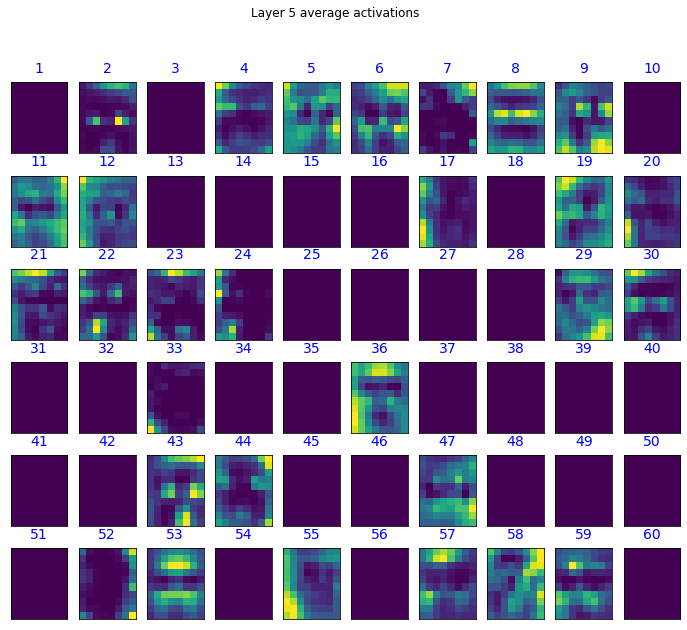

In [ ]:
#load model to be repaired
#RepairedModel = keras.models.load_model(path)
#RepairedModel.compile(optimizer = 'adam',loss = loss_func,metrics=['accuracy'])

#extract layers
layer = BadModel.layers[5].output
activationModel = models.Model(inputs=BadModel.input, outputs=layer)
layerActivations = activationModel.predict(valCleanX)

imageNum = layerActivations.shape[0]
chanelActivations = np.zeros([10, 8, 60])
#set chanel activations
for image in range(imageNum): #go through all images 
  chanelActivations[:,:,:] += layerActivations[image,:,:,:]

chanelActivations = chanelActivations/imageNum

#compute average activation for each chanel
averageChanelActivation = []
for chanel in range(60): #there are 60 chanels
  activation = np.sum(chanelActivations[:,:,chanel]/80)
  averageChanelActivation.append(activation)

#sort activations in ascending order while maintaining an index of chanels
activationRef = dict() #create an empty dict

for idx,value in enumerate(averageChanelActivation):
  activationRef[idx] = value

sortedActivations = sorted(activationRef.items(), key=lambda x: x[1])

#display chanel activations
plt.figure(figsize=(12,10))
plt.suptitle('Layer 5 average activations')
for i in range(6):
    for j in range(10):
        ax = plt.subplot2grid((6,10), (i,j))
        ax.matshow(chanelActivations[:,:,i*10+j])
        ax.set_title(str(i*10+j+1), fontsize=14,color='b')
        ax.set_xticks([])
        ax.set_yticks([])
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

## Pruning the Badnet: Creating Repaired Networks

In [ ]:
#let us now finally get to pruning
#we will prune on validation data
def pruneModel(targetAcc,path,valCleanX,valCleanY,testBadX,testBadY):
  #targetAcc is given as either 0.02, 0.04 or 0.10 
  RepairedModel = keras.models.load_model(path)
  RepairedModel.compile(optimizer = 'adam',loss = loss_func,metrics=['accuracy'])

  weights,biases = RepairedModel.layers[5].get_weights()

  baseLoss, baseAcc = RepairedModel.evaluate(valCleanX,valCleanY,verbose=2)
  threshold = 0
  run = 0
  for i in range(60): #number of chanels to prune

    index = sortedActivations[i][0]
    weights[:,:,:,index] = np.zeros((3,3,40)) #setting weights to zero
    biases[index] = 0 #setting biase to zero 
    RepairedModel.layers[5].set_weights([weights,biases])
    newLoss, newAcc = RepairedModel.evaluate(valCleanX,valCleanY,verbose=2)
    threshold = baseAcc - newAcc
    run+=1
    
    if threshold >= targetAcc:
      break
  
  chanelsPrunedFraction = run/60
  repLoss, repAcc = RepairedModel.evaluate(valCleanX,valCleanY,verbose=2)
  a, attackSuccess = RepairedModel.evaluate(testBadX, testBadY, verbose=0)

  return RepairedModel, chanelsPrunedFraction, repAcc, attackSuccess

In [ ]:
RepairedModel_2, chanelsPrunedFraction_2, repAcc_2, attackSuccess_2 = pruneModel(0.02,path,valCleanX,valCleanY,testBadX,testBadY)

In [ ]:
RepairedModel_4, chanelsPrunedFraction_4, repAcc_4, attackSuccess_4 = pruneModel(0.04,path,valCleanX,valCleanY,testBadX,testBadY)

In [ ]:
RepairedModel_10, chanelsPrunedFraction_10, repAcc_10, attackSuccess_10 = pruneModel(0.10,path,valCleanX,valCleanY,testBadX,testBadY)

In [ ]:
print('For our 2% repaired model, we have the following metrics:')
print('Fraction of chanels pruned: ',chanelsPrunedFraction_2)
print('Accuracy on the clean validation dataset: ', repAcc_2)
print('Attack success rate: ',attackSuccess_2)
print('------------------------------------------------------')

print('For our 4% repaired model, we have the following metrics:')
print('Fraction of chanels pruned: ',chanelsPrunedFraction_4)
print('Accuracy on the clean validation dataset: ', repAcc_4)
print('Attack success rate: ',attackSuccess_4)
print('------------------------------------------------------')

print('For our 10% repaired model, we have the following metrics:')
print('Fraction of chanels pruned: ',chanelsPrunedFraction_10)
print('Accuracy on the clean validation dataset: ', repAcc_10)
print('Attack success rate: ',attackSuccess_10)
print('------------------------------------------------------')


For our 2% repaired model, we have the following metrics:
Fraction of chanels pruned:  0.75
Accuracy on the clean validation dataset:  0.9575647115707397
Attack success rate:  1.0
------------------------------------------------------
For our 4% repaired model, we have the following metrics:
Fraction of chanels pruned:  0.8
Accuracy on the clean validation dataset:  0.943448543548584
Attack success rate:  0.9998441338539124
------------------------------------------------------
For our 10% repaired model, we have the following metrics:
Fraction of chanels pruned:  0.8666666666666667
Accuracy on the clean validation dataset:  0.8443751335144043
Attack success rate:  0.7720966339111328
------------------------------------------------------


Let us now visualize how the 3 networks performed

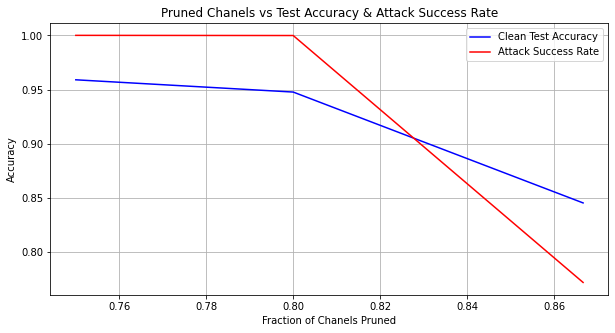

In [ ]:
#generate graphs for validation accuracy and attack success rate 
#testLoss_2, testAcc_2 = RepairedModel_2.evaluate(testCleanX,testCleanY,verbose=2)
#testLoss_4, testAcc_4 = RepairedModel_4.evaluate(testCleanX,testCleanY,verbose=2)
#testLoss_10, testAcc_10 = RepairedModel_10.evaluate(testCleanX,testCleanY,verbose=2)

prunedFractions = [chanelsPrunedFraction_2,
                   chanelsPrunedFraction_4,
                   chanelsPrunedFraction_10]

testAccuracy = [testAcc_2,
                testAcc_4,
                testAcc_10]

attackSuccess = [attackSuccess_2,
                 attackSuccess_4,
                 attackSuccess_10]

plt.figure(figsize=(10,5))
plt.title('Pruned Chanels vs Test Accuracy & Attack Success Rate')
plt.plot(prunedFractions,testAccuracy, 'b')
plt.plot(prunedFractions,attackSuccess, 'r')
plt.legend(['Clean Test Accuracy', 'Attack Success Rate'], fontsize=10)
plt.xlabel('Fraction of Chanels Pruned')
plt.ylabel('Accuracy')
plt.grid()
#plt.plot(scaled_adjusted_number_of_channels_pruned, adjusted_attack_success_rate, 'g',)

## GoodNet

For the goodnet, we will simply feed the network with test data (mix of bad and good) and compare the outputs. If outputs do not match, then we will assign N+1 as the prediction

In [ ]:
#goodnet time
def GoodNet(BadNet,RepairedNet,testX,N):
  badPredictions = np.argmax(BadNet.predict(testX), axis=1)
  repairedPredictions = np.argmax(RepairedNet.predict(testX), axis=1)

  correctPredictions = []
  badImages = []

  predictionsCount = len(badPredictions)
  for i in range(predictionsCount):
    badPred = badPredictions[i]
    repPred = repairedPredictions[i]

    if badPred == repPred:
      correctPredictions.append([i,badPred])
    else:
      badImages.append([i,N+1])
  
  return correctPredictions, badImages

In [ ]:
#get the mislabelled images
correctPredictions_2, badImages_2 = GoodNet(BadModel,RepairedModel_2,testBadX,1283)
correctPredictions_4, badImages_4 = GoodNet(BadModel,RepairedModel_4,testBadX,1283)
correctPredictions_10, badImages_10 = GoodNet(BadModel,RepairedModel_10,testBadX,1283)

#print number of misclassified images that were detected by our goodnet
print('Number of misclassified images in 2% model: ',len(badImages_2))
print('Number of misclassified images in 4% model: ',len(badImages_4))
print('Number of misclassified images in 10% model: ',len(badImages_10))

Number of misclassified images in 2% model:  0
Number of misclassified images in 4% model:  2
Number of misclassified images in 10% model:  2924


We now look at the number of misclassified images. As can be seen, the 10% model has the highest number of N+1 predictions which means that it performs the best at defending attacks. For the 2% and 4% model, we see that all images go through the network undetected with the exception of only 2 images for the 4% model.